In [211]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate data

In [212]:
def noisy_sinusoid(t,amplitude,frequency,noise_rms,seed=None):
    
    seed = seed if seed is not None else np.random.randint(0,2**31)
    rng = np.random.default_rng(seed)

    # Our data consists of a signal and noise
    signal = amplitude * np.sin(t*(2*np.pi*frequency))
    noise = rng.normal(loc=0,scale=noise_rms,size=len(t))

    # Our Uncertainties come from the white noise, which is the same throughout (homoscedastic)
    uncertianties = np.ones(len(t)) * noise_rms

    return signal + noise, uncertianties


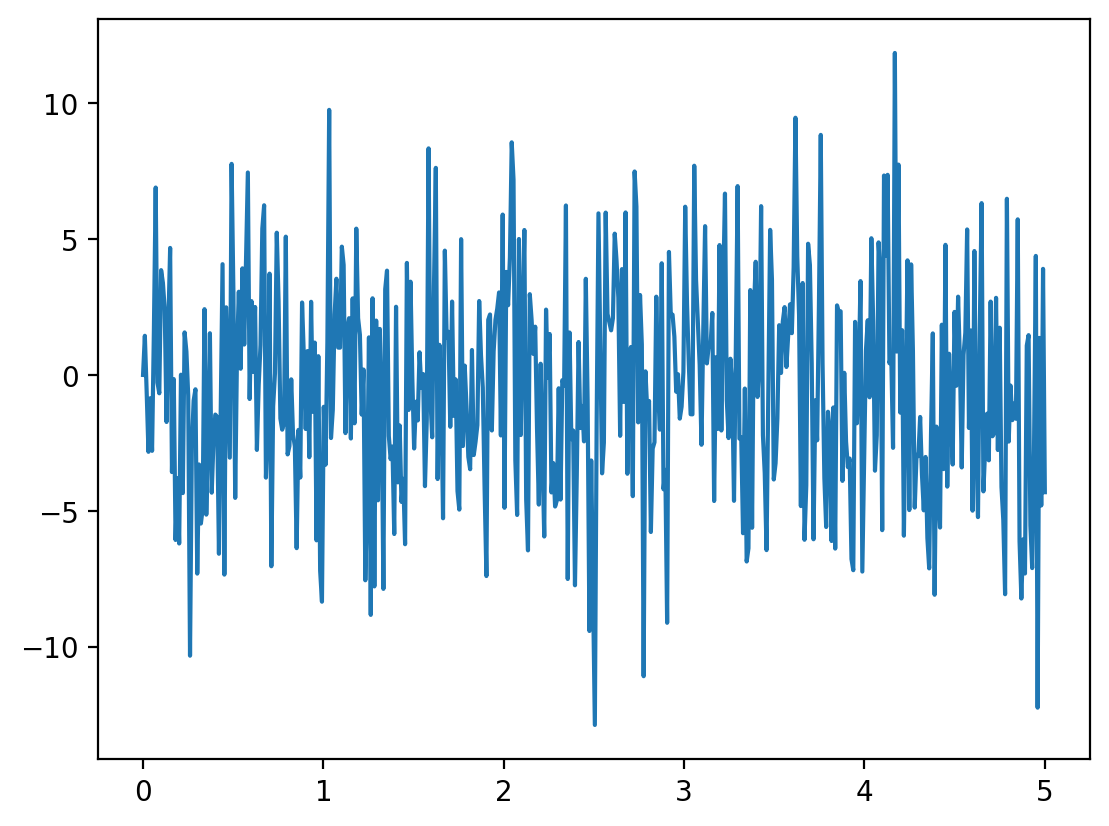

In [213]:
# Assign truth values
truths = {'amplitude':2,'frequency':2}

t = np.linspace(0,5,500)
data, uncertianty = noisy_sinusoid(t, amplitude=truths['amplitude'],
                                   frequency=truths['frequency'],
                                   noise_rms=4, seed=7)

plt.plot(t,data)
plt.show()


In [214]:
# Create the model
def sinusoid_model(t,amplitude,frequency):
    signal = amplitude * np.sin(t*(2*np.pi*frequency))
    return signal

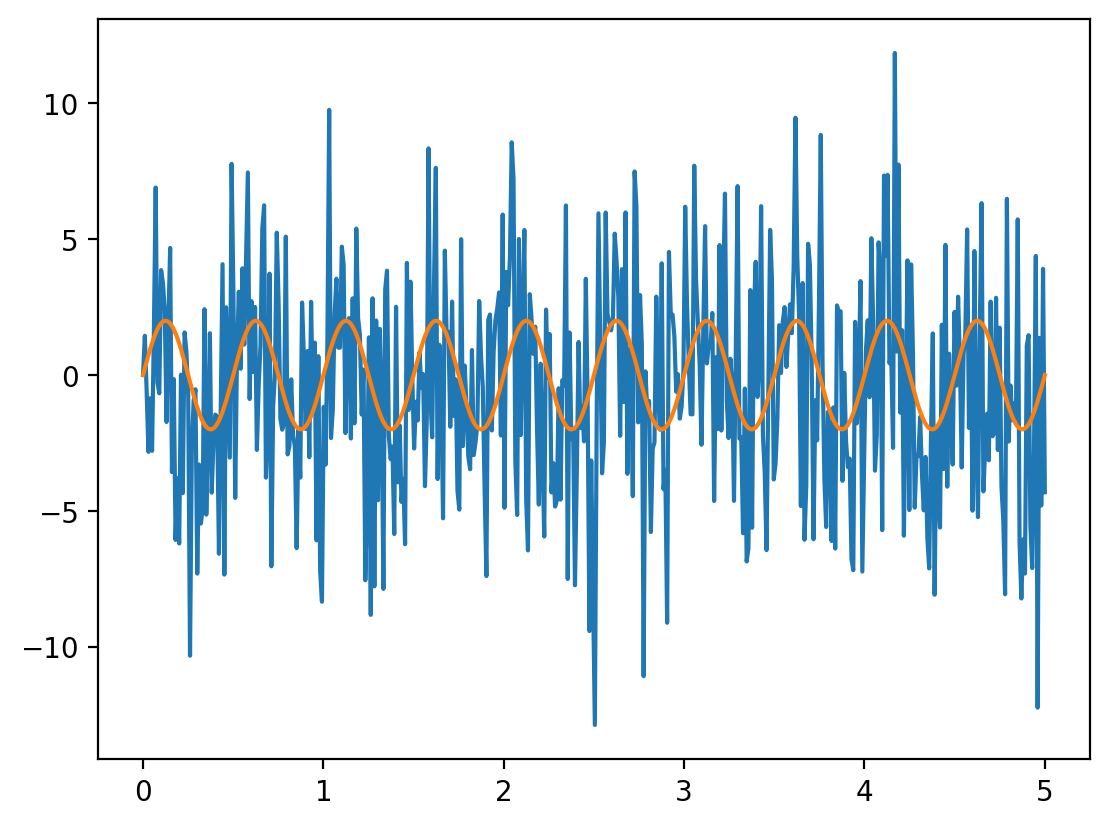

In [215]:
# Since we generated the data, lets see what our model overlay looks like
inj_model = sinusoid_model(t, truths['amplitude'], truths['frequency'])
plt.plot(t,data)
plt.plot(t,inj_model)
plt.show()


The Gaussian likelihood function is

$$ p(d|m) = \prod_{i=1}^{N} \frac{1}{\sqrt{2 \pi \sigma_i^2 }} \exp\left(\frac{-(d_i - m_i)^2}{2 \sigma_i^2}\right) .$$

Where $d_i$, $m_i$, and $\sigma_i$ are the $i^{\rm{th}}$ element of the data, model and uncertainty in the data respectively. Importantly, we can see that because of the product operator, this quantity can either be absurdly small (in the case where most $d_i - m_i < 0$), or absurdly large (in the case where most $d_i - m_i > 0$). This is a problem for computers since we have a limited range of floating point values to use. 

To combat this, it is often much easier to work in log space. We need to rewrite our function for the log space by taking the natural log of the expression. Note that $\ln(\prod_i^N a_i) = \sum_i^N \ln(a_i) $.

$$ \ln( p(d|m) ) = 
- \frac{1}{2} \sum_{i=1}^{N} \left( \ln(2 \pi \sigma_i^2) + \left(\frac{(d_i - m_i)^2}{ \sigma_i^2}\right) \right) 
= 
- \frac{1}{2} \sum_{i=1}^{N} \ln(2 \pi \sigma_i^2) - \frac{1}{2} \sum_{i=1}^{N} \left(\frac{(d_i - m_i)^2}{ \sigma_i^2}\right) .$$


In [216]:
# Now we need to make our log likelihood function

def ln_likelihood(params):
    """Params must be in [amplitude, frequency] order!"""

    amplitude = params[0]
    frequency = params[1]

    model = sinusoid_model(t,amplitude,frequency)
    residuals = data - model

    term1 = -(1/2)*np.sum( np.log(2*np.pi*uncertianty**2) )
    term2 = -(1/2)*np.sum( residuals**2/uncertianty**2 ) 
    return term1 + term2
    



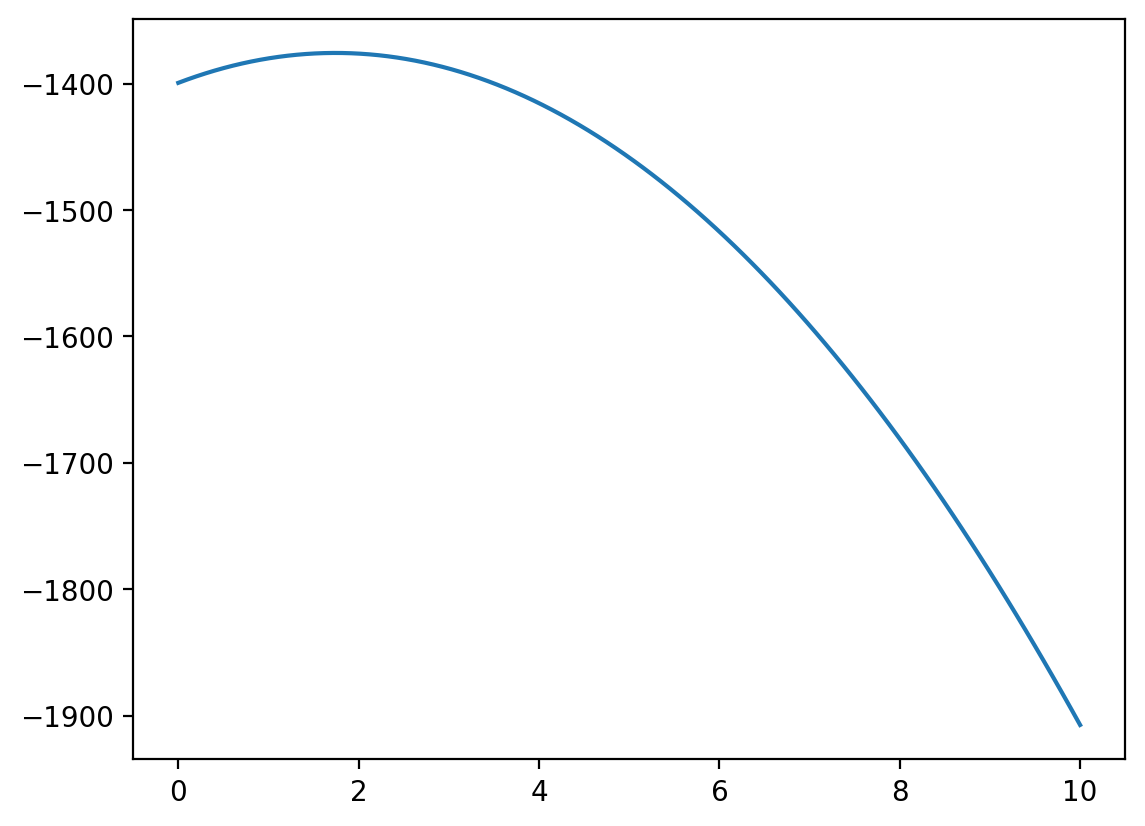

In [217]:
# Quick test. Lets vary one parameter and hold the others fixed. 
a_range = np.linspace(0,10,100)
ln_like_a = [ln_likelihood([a,truths['frequency']]) for a in a_range]
plt.plot(a_range,ln_like_a)

In [218]:
# Priors

# We do have some specifications for our parameters
def ln_prior(params):
    """Params must be in [amplitude, frequency] order!"""

    amplitude = params[0]
    frequency = params[1]

    # We want to enforce a positive amplitude less than 10 (finite prior)
    if amplitude<0 or amplitude>10:
        return -np.inf
    # We want to enforce a positive frequency less than 10 (finite prior)
    if frequency<0 or frequency>10:
        return -np.inf
    
    # If we get here, we want a uniform prior over the range
    # Our space spans (10-0)*(10-0) = 100
    prior = 1/(100)
    return np.log(prior)

In [219]:
# Now we need to introduce sampling

def mh_mcmc(x0, N, cov, ln_like, ln_prior):
    chain = np.zeros((N,len(x0)))
    acceptance = 0

    # Current unnormalized posterior
    cur_val = x0
    cur_post = ln_prior(cur_val) + ln_like(cur_val)
    chain[0] = cur_val

    for i in tqdm(range(1,N),ncols=80,desc='MCMC iterations'):
        # Add a small random gaussian offset to current position
        new_val = cur_val + np.random.multivariate_normal( np.zeros(len(cur_val)), cov)

        new_post = ln_prior(new_val) + ln_like(new_val)

        # Use hastings ratio to decide on jumping
        ln_Hastings = new_post - cur_post
        if ln_Hastings > 1 or np.exp(ln_Hastings)>np.random.random():
            acceptance+=1
            chain[i] = new_val
            cur_val = new_val
            cur_post = new_post
        else:
            chain[i] = cur_val
    
    print(f'Done. Acceptance rate = {100*(acceptance/N)}%')
    return chain 


In [220]:
x0 = [1.0,1.0]
cov = np.diag([0.001,0.001])
chain = mh_mcmc(x0,int(3e5),cov,ln_likelihood,ln_prior)


MCMC iterations: 100%|███████████████| 999999/999999 [01:16<00:00, 13036.59it/s]

Done. Acceptance rate = 28.186099999999996%


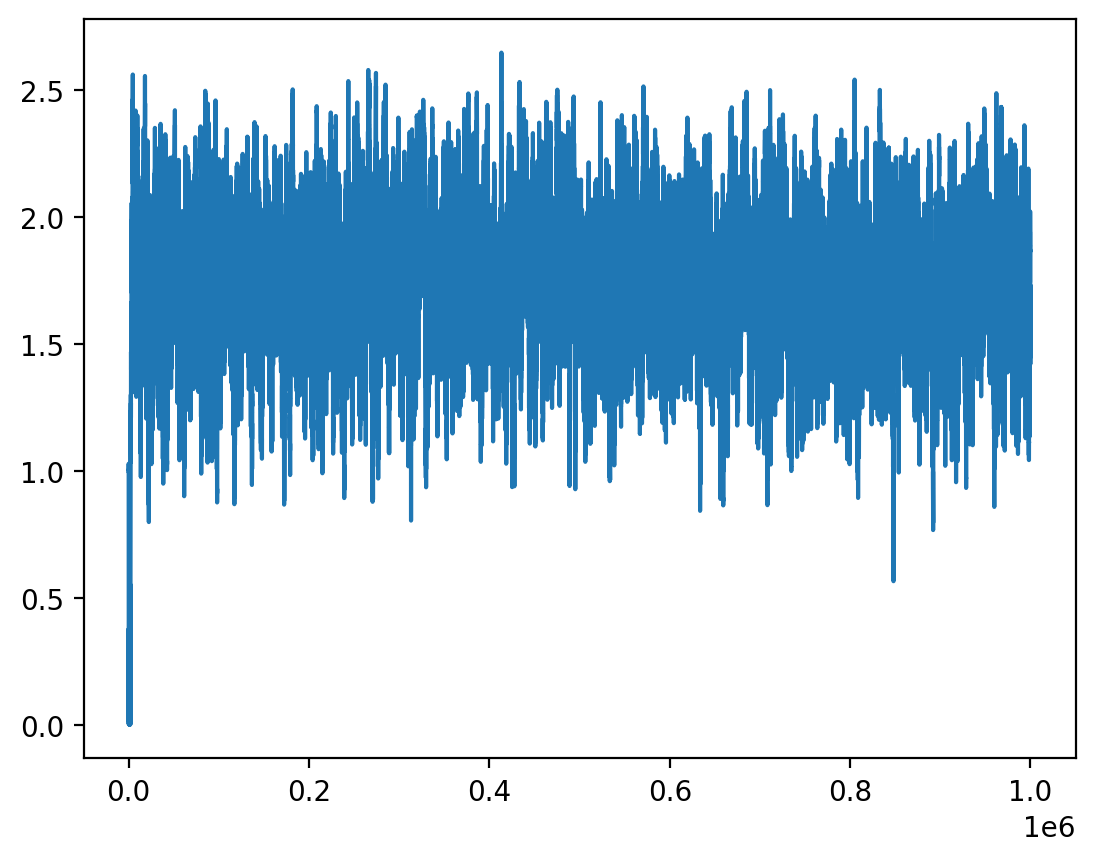

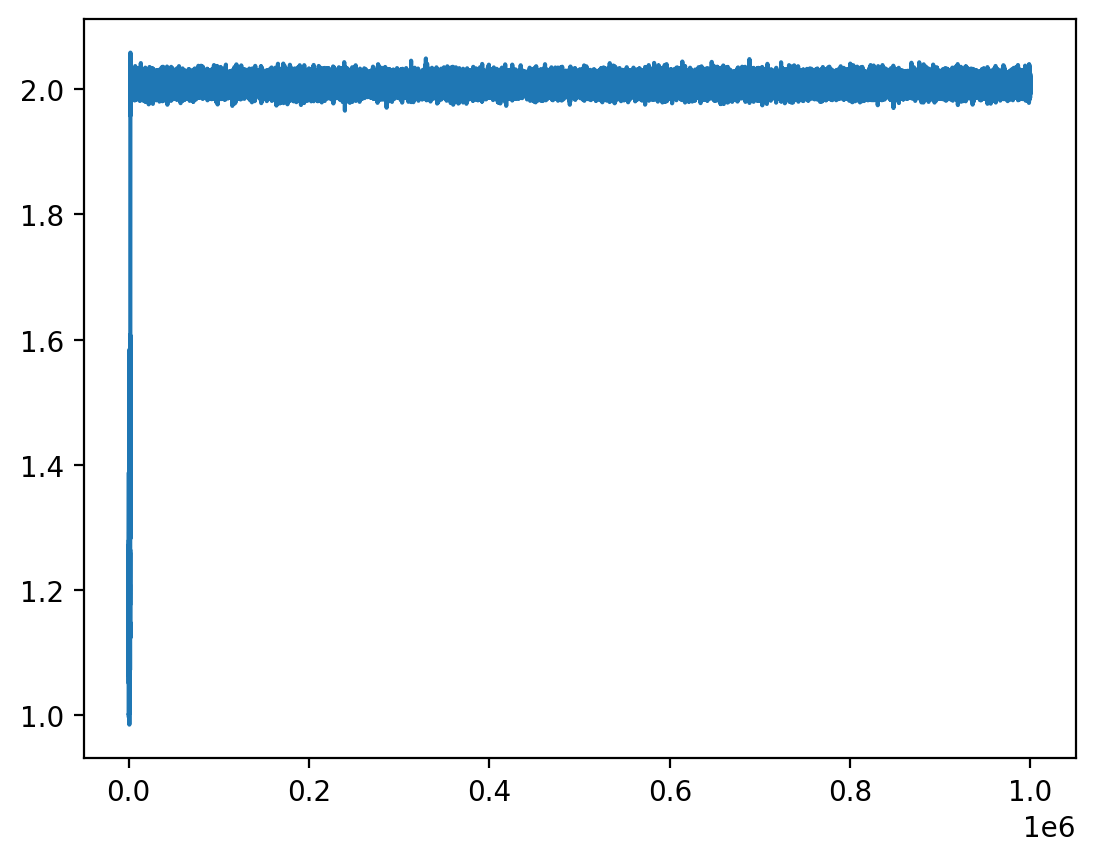

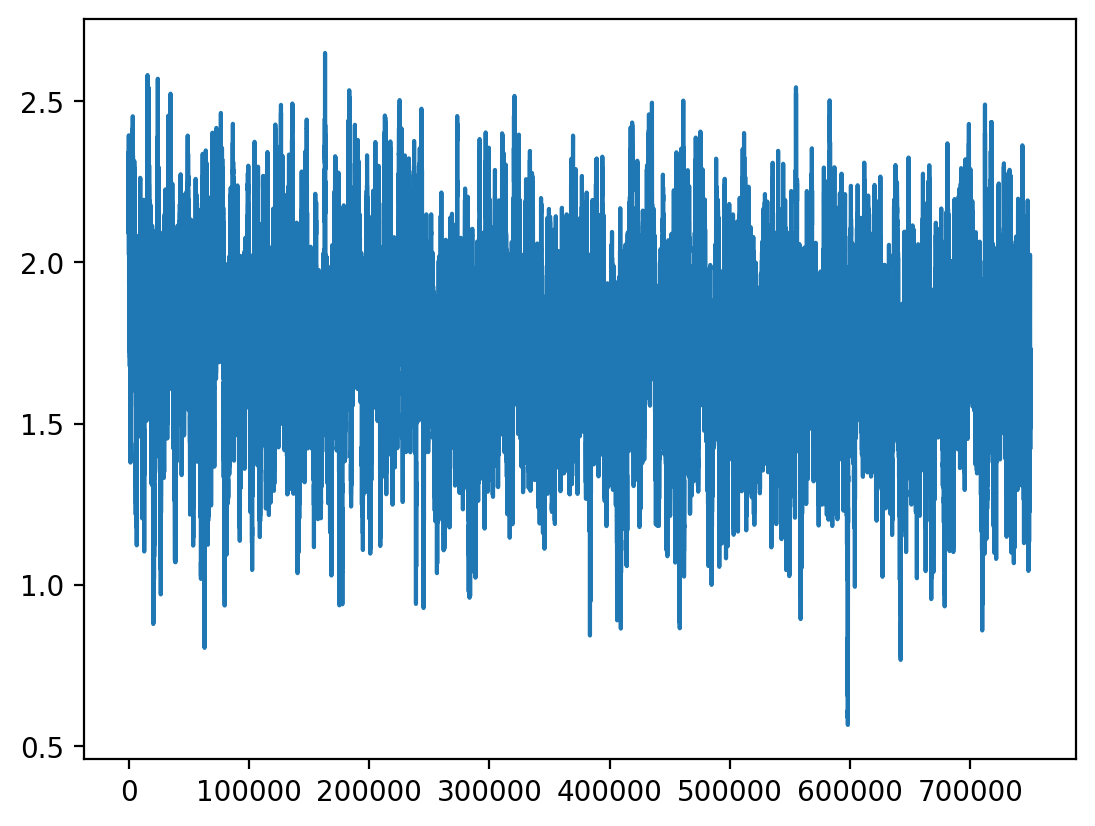

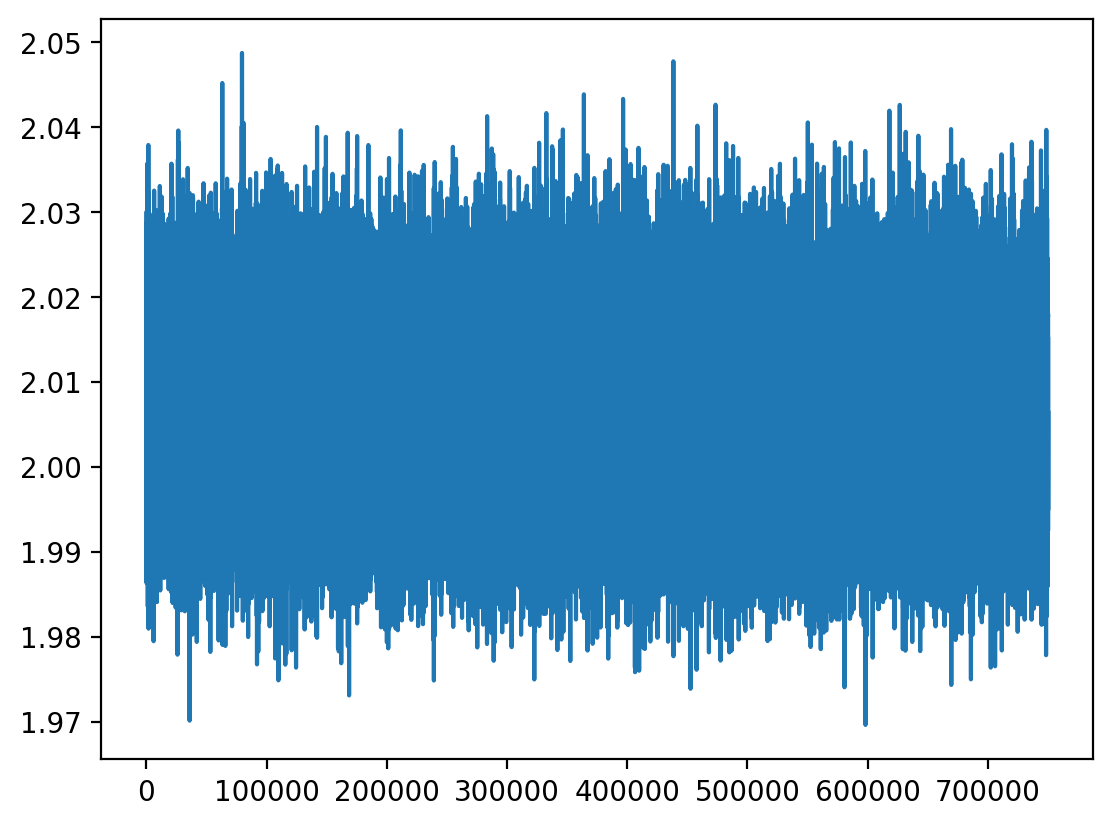

In [221]:
plt.plot(chain[:,0])
plt.show()
plt.plot(chain[:,1])
plt.show()

burn = int(0.25*len(chain))

plt.plot(chain[burn:,0])
plt.show()
plt.plot(chain[burn:,1])
plt.show()

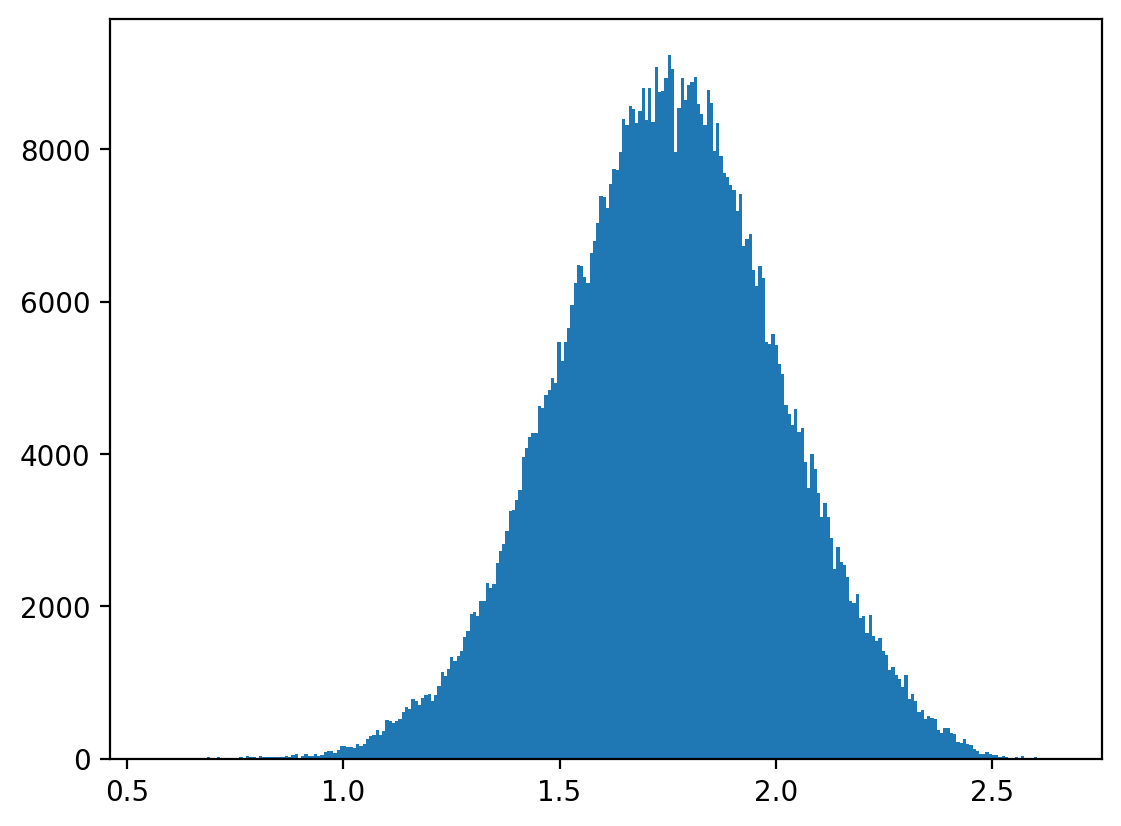

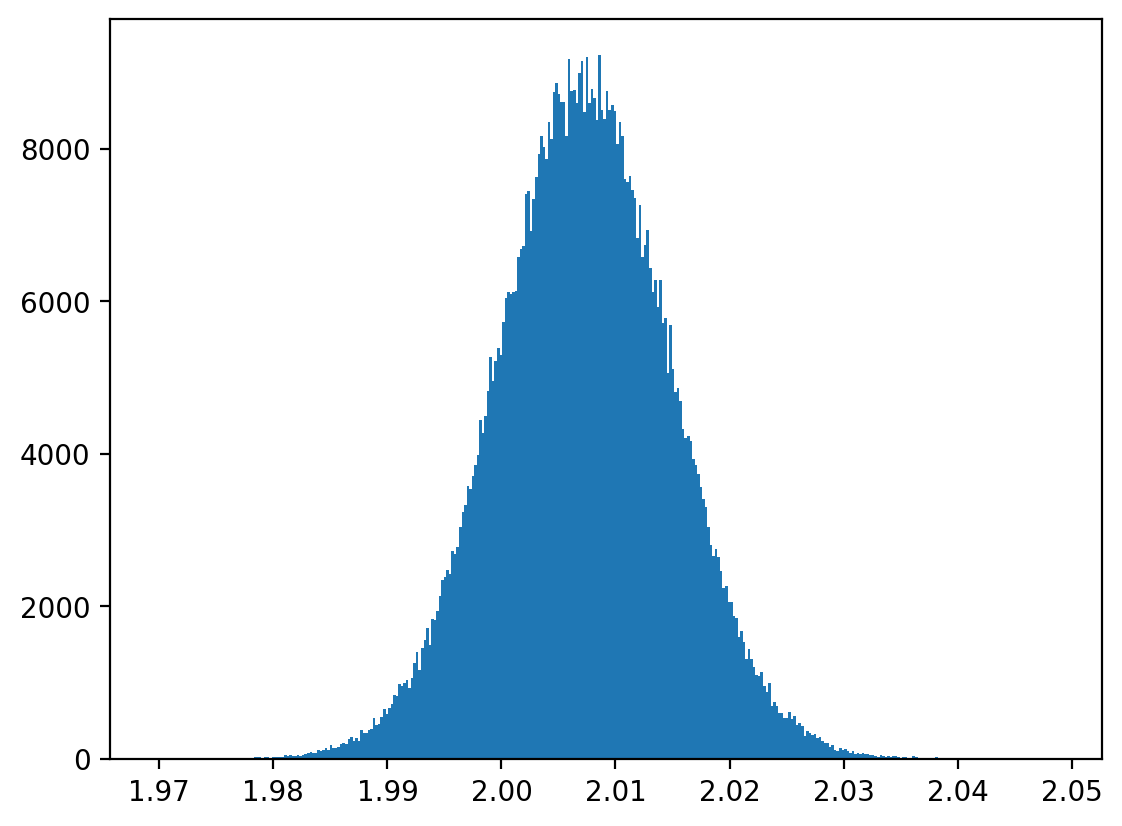

In [222]:
plt.hist(chain[burn:,0],bins='auto')
plt.show()

plt.hist(chain[burn:,1],bins='auto')
plt.show()


In [223]:
# Okay, so my sampler isn't the best lets use a more robust one! 
from PTMCMCSampler.PTMCMCSampler import PTSampler


In [224]:
loc = 'SimpleSineMCMC/'
sampler = PTSampler(2,ln_likelihood,ln_prior,cov,outDir=loc)

In [225]:
sampler.sample(np.array([0.1,0.1]),int(3e5))

Finished 1.00 percent in 0.754126 s Acceptance rate = 0.099433Adding DE jump with weight 20
Finished 100.00 percent in 71.501742 s Acceptance rate = 0.268832
Run Complete


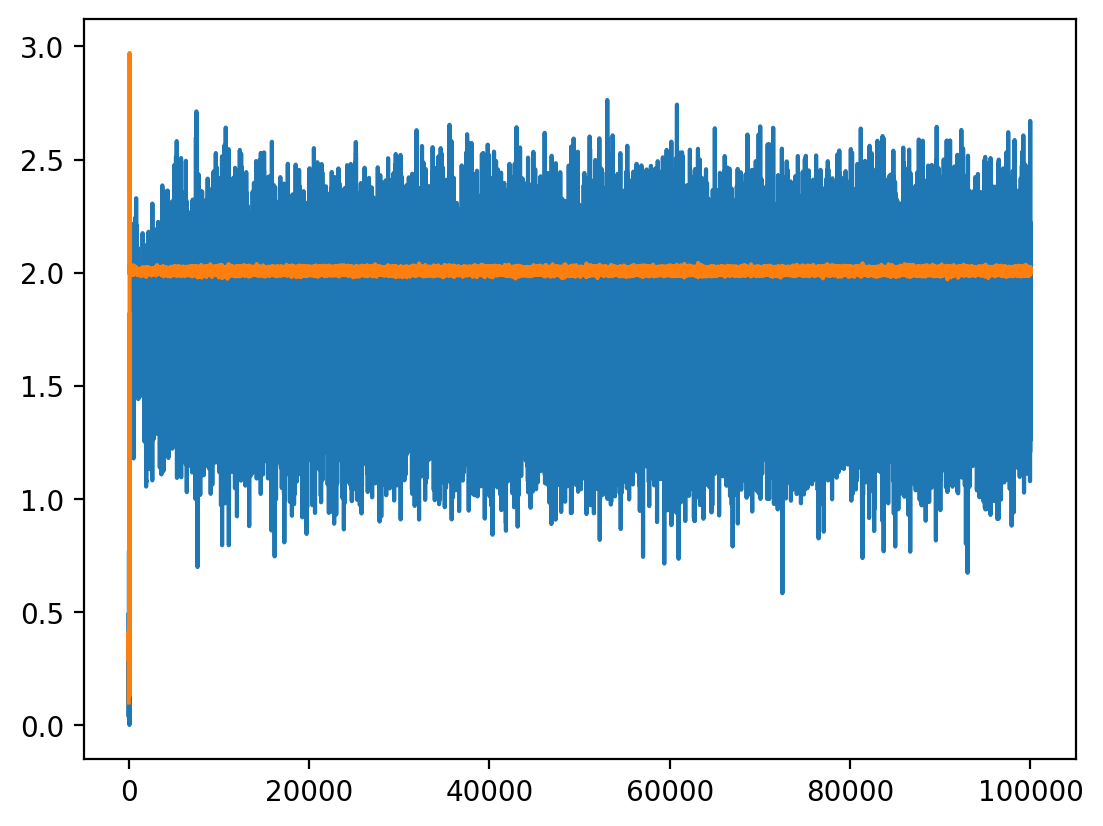

In [226]:
chain = np.loadtxt(loc+'chain_1.txt')
plt.plot(chain[:,0])
plt.plot(chain[:,1])

In [227]:
# Much better

In [228]:
# Now that we have parameter estimates, what do we do with them? How do we know how significant they are?

# You can do this through Bayesian model selection (AKA Bayesfactors)

# You can get a Savage-Dickey Bayesfactor by evaluating the ratio of prior(amplitude=0)/posterior(amplitude=0)
# But in cases like this, it might be hard to get any samples down in the tails of the distributions!

# One numerical method that is often used in PTAs is estimating the null-distribution. 
# We can test how important the presence of something is by creating statistically identical datasets with
# the signal removed.

# One question though, how? If we want to remove our signal, but we don't even know what it is, how can we do that?

# The answer is to find methods to destroy the signal while keeping every other property in place

In [229]:
# With our sinusoid example, we have a dataset which contains a time-varying signal with 
# non-time varying noise. So what if we scrambled the time axis?

# There are many methods to do this, but for this example I will be using a technique called bootstrapping
# If we assume that each measurement is independent and no signal is present, then each measurement
# is a random draw from the white noise. We can then create bootstrapped datasets by taking N random samples
# from our real dataset to construct a new non-time-varrying dataset

In [230]:
def create_bootstrap(data,seed=None):
    seed = seed if seed is not None else np.random.randint(0,2**30)
    rng = np.random.default_rng(seed)

    randi = rng.integers(0,len(data),len(data))
    new = np.zeros_like(data)
    new = data[randi]
    return new

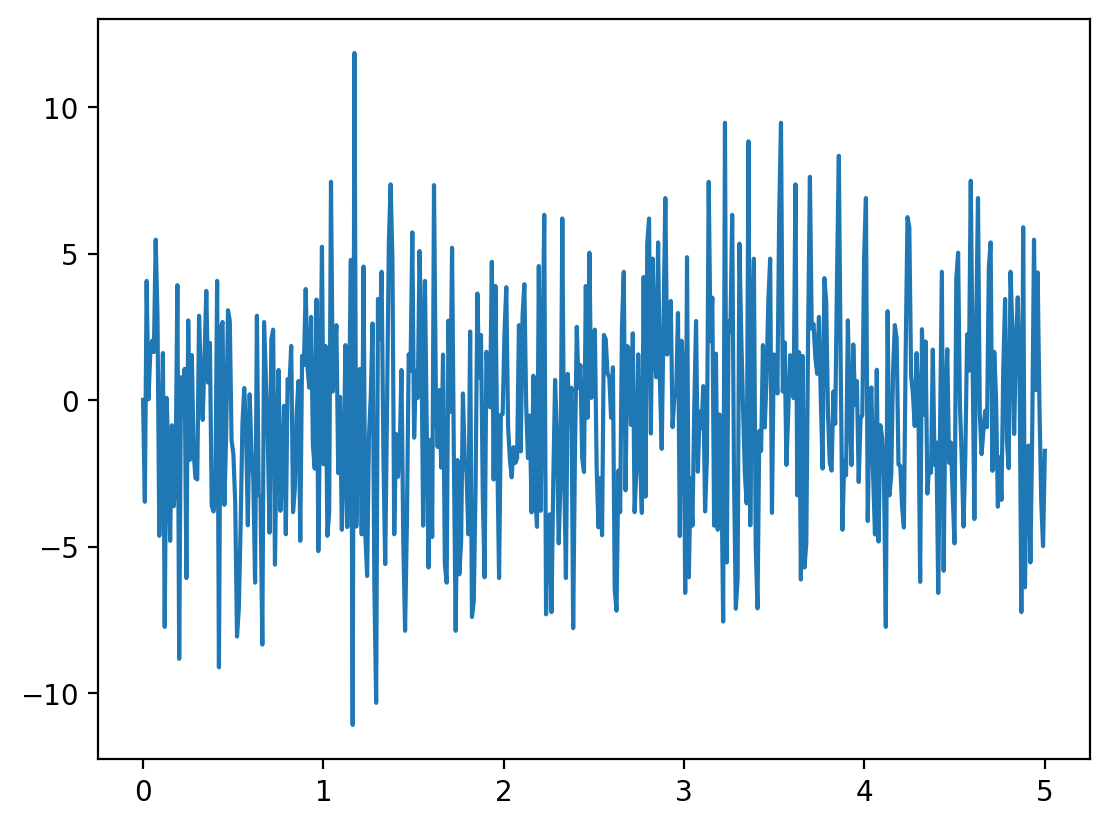

In [231]:
# See a sinusoid anymore?

bootstrap = create_bootstrap(data,49)

plt.plot(t,bootstrap)

In [232]:
def bootstrap_ln_likelihood(params):
    """Params must be in [amplitude, frequency] order!"""

    amplitude = params[0]
    frequency = params[1]

    model = sinusoid_model(t,amplitude,frequency)
    residuals = bootstrap - model

    term1 = -(1/2)*np.sum( np.log(2*np.pi*uncertianty**2) )
    term2 = -(1/2)*np.sum( residuals**2/uncertianty**2 ) 
    return term1 + term2
    

In [233]:
loc = 'BootstrapSineMCMC/'
sampler = PTSampler(2,bootstrap_ln_likelihood,ln_prior,cov,outDir=loc)

sampler.sample(np.array([0.0,0.0]),int(3e5))

Finished 1.00 percent in 0.621848 s Acceptance rate = 0.338511Adding DE jump with weight 20
Finished 100.00 percent in 65.253498 s Acceptance rate = 0.310573
Run Complete


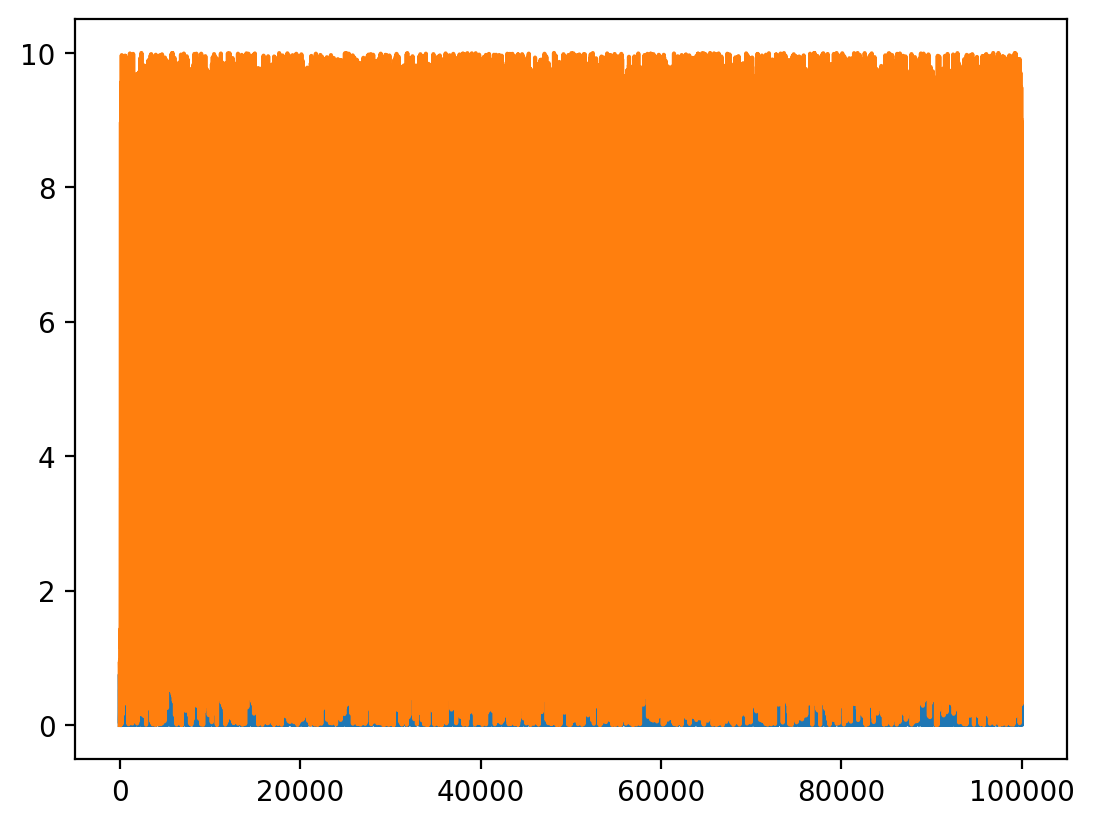

In [234]:
chain = np.loadtxt(loc+'chain_1.txt')
plt.plot(chain[:,0])
plt.plot(chain[:,1])

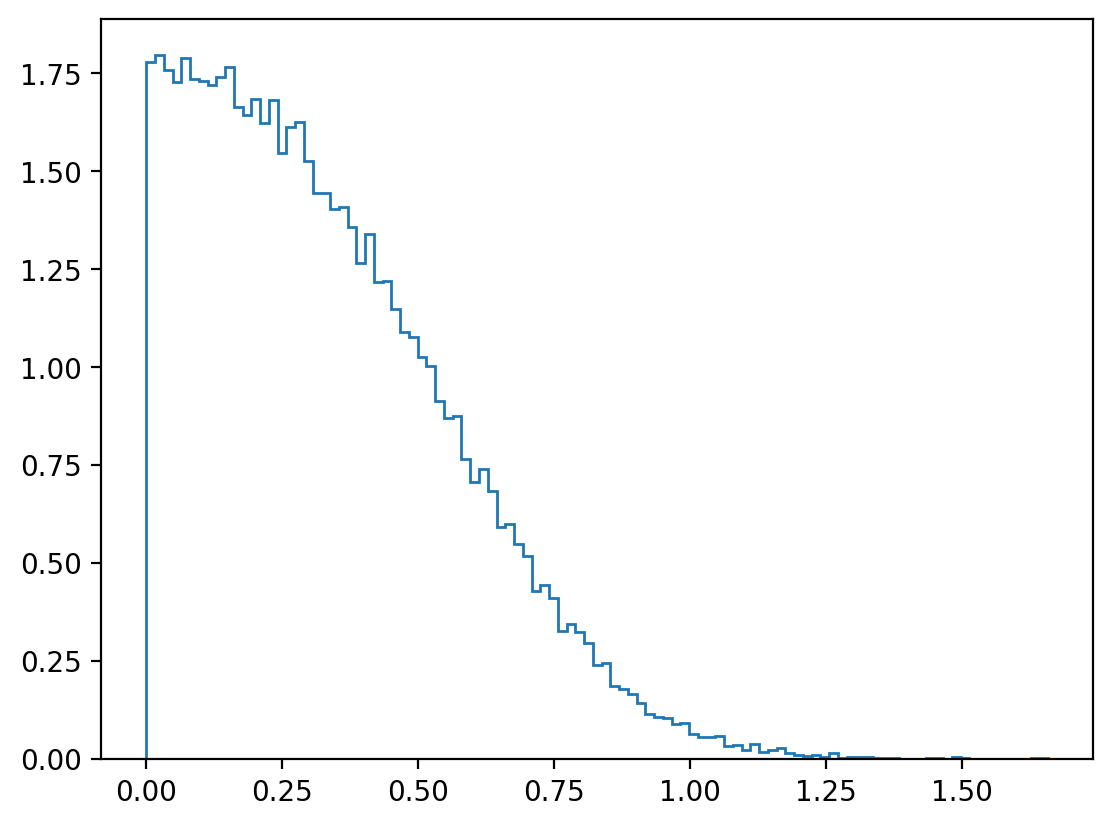

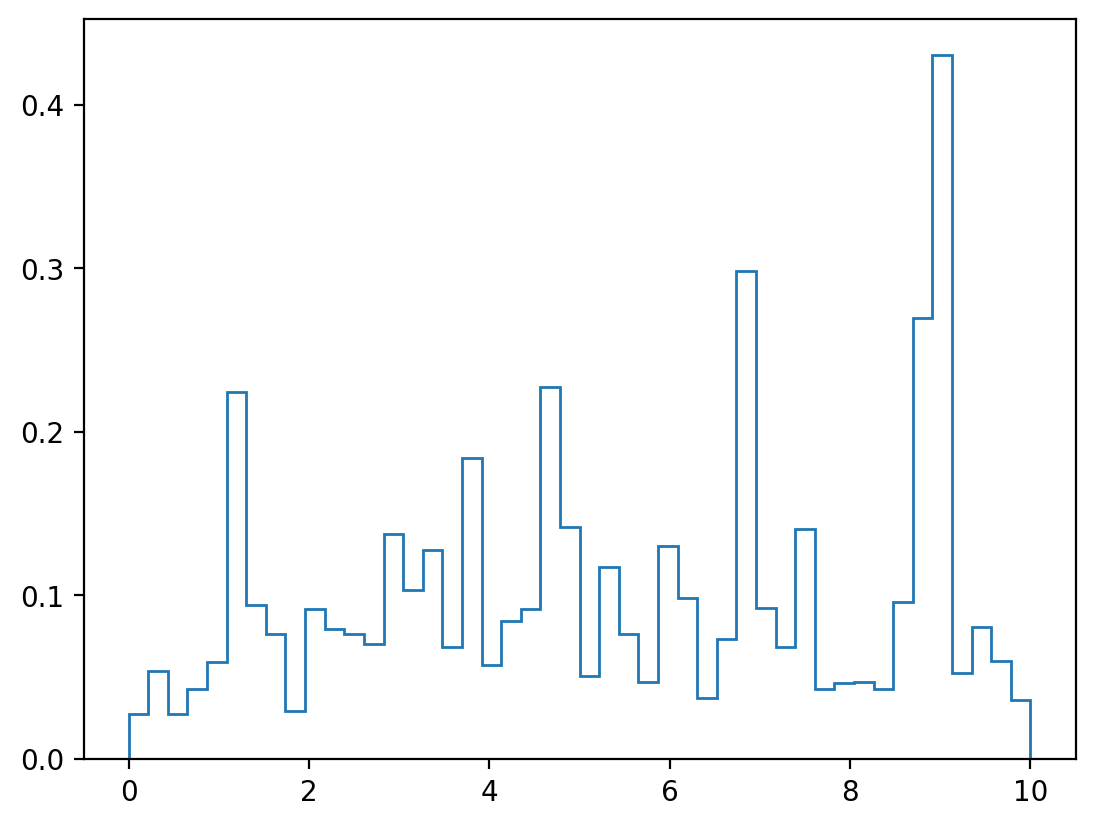

In [245]:
burn = int(0.25*len(chain))

plt.hist(chain[burn:,0],'auto',histtype='step',density=True)
plt.show()
plt.hist(chain[burn:,1],'auto',histtype='step',density=True)
plt.show()